In [653]:
import glob, csv, subprocess
import os
import os.path
import scipy
import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'plasma'

In [3]:
os.chdir('/imaging/jj02/PyPackages/neurolib')

In [1]:
# change to the root directory of the project
import os
if os.getcwd().split("/")[-1] == "examples":
    os.chdir('..')
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2    

In [4]:
from nilearn.plotting import plot_matrix

In [5]:
from neurolib.models.aln import ALNModel
from neurolib.utils.loadData import Dataset
import neurolib.utils.functions as func
from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.optimize.exploration import BoxSearch

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [584]:
fc_dir = '/imaging/jj02/CALM/functional_connectomes/DK/Conn_denoised_time-series'
sc_dir = '/imaging/jj02/CALM/structural_connectomes/dk-68'

# HCP Benchmarking

In [585]:
from neurolib.utils.loadData import Dataset
ds = Dataset("gw")

MainProcess root INFO     Loading dataset gw from /imaging/jj02/PyPackages/neurolib/neurolib/utils/../data/datasets/gw.
MainProcess root INFO     Dataset gw loaded.


How many Zero edges? 109


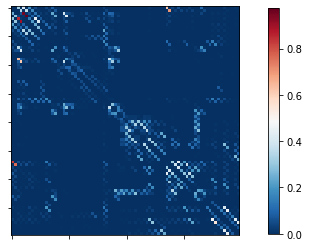

In [586]:
plot_matrix(ds.Cmat,  figure=(4,4))
print('How many Zero edges?', np.count_nonzero(ds.Cmat==0))

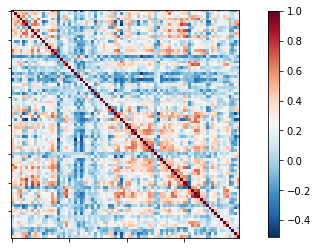

In [587]:
plot_matrix(ds.FCs[0], figure=(4,4))

## SC-FC Correlation

In [664]:
def matrix_correlation(M1, M2, N_ROIs):
    """Compute the Pearson and Spearman correlation from the upper triangle of two matrices of shape (N_ROIs, N_ROIs).
    Uses scipy. Stores pearson and spearman results in assigned object"""
    from scipy.stats import pearsonr, spearmanr
    
    m1 = M1[np.triu_indices(N_ROIs, k=1)]
    m2 = M2[np.triu_indices(N_ROIs, k=1)]
    
    class matrix_corr:
        pearson = pearsonr(m1,m2)
        spearman = spearmanr(m1,m2)
        plt.figure(figsize=(4, 3))
        plot = plt.scatter(m1, m2)
    
    print('Pearson correlation R = %.03f, p =  %.04f' % (matrix_corr.pearson))
    print('Spearman correlation R = %.03f, p =  %.04f' % (matrix_corr.spearman))
    return matrix_corr

Pearson correlation R = 0.319, p =  0.0000
Spearman correlation R = 0.515, p =  0.0000


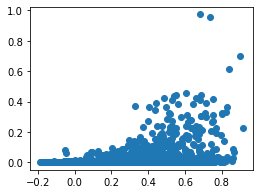

In [665]:
a = matrix_correlation(ds.mean_fc, ds.Cmat, 80)

In [669]:
for n, fc, sc in zip(range(5), ds.FCs, ds.Cmats):
    print('## Subject %d' % (n+1))
    matrix_correlation(fc, sc, 80)
    plt.close()

## Subject 1
Pearson correlation R = 0.249, p =  0.0000
Spearman correlation R = 0.327, p =  0.0000
## Subject 2
Pearson correlation R = 0.227, p =  0.0000
Spearman correlation R = 0.453, p =  0.0000
## Subject 3
Pearson correlation R = 0.264, p =  0.0000
Spearman correlation R = 0.371, p =  0.0000
## Subject 4
Pearson correlation R = 0.245, p =  0.0000
Spearman correlation R = 0.432, p =  0.0000
## Subject 5
Pearson correlation R = 0.273, p =  0.0000
Spearman correlation R = 0.431, p =  0.0000


# Load Structural & Functional Connectivity

## Find valid subjects

In [7]:
sc_files = sorted(glob.glob(sc_dir + '/matrices/CSD_SC/*.csv'))
fc_files = sorted(glob.glob(fc_dir + '/results/full_cormats_85/*.csv'))

all_sc_subs = [os.path.basename(i)[:7] for i in sc_files]
all_fc_subs = [os.path.basename(i)[:7] for i in fc_files]
subs = set(all_sc_subs) & set(all_fc_subs)

print('%d subjects with good SC data,\n%d subjects with good FC data,\n%d subjects with both' 
      % (len(all_sc_subs), len(all_fc_subs), len(subs)))

278 subjects with good SC data,
242 subjects with good FC data,
162 subjects with both


- 1 missing SC subject - maybe one subject was repeated? CBU160489?
- Needs updating with new BIDS subject list

## Load SC

In [364]:
sc = []
for i in sc_files:
    sub = os.path.basename(i)[:7]
    
    if sub in subs:
        sc_mat = np.loadtxt(i, delimiter=',')
        sc.append(sc_mat)

sc = np.asarray(sc)
print("SC shape:", sc.shape)
mean_sc = np.mean(sc, axis=0)

SC shape: (162, 68, 68)


### Normalise 0-1

In [365]:
minimum = np.min(mean_sc)
maximum = np.max(mean_sc)
for i in range(mean_sc.shape[0]):
    for j in range(mean_sc.shape[1]):
        x = mean_sc[i,j]
        mean_sc[i,j] = (x-minimum)/(maximum-minimum)
        
# Fill diagonal to 0
np.fill_diagonal(mean_sc, 0)

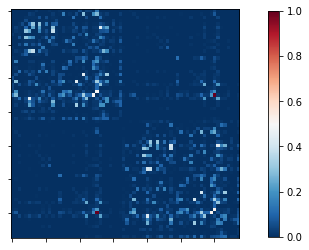

In [366]:
plot_matrix(mean_sc, figure = (4, 4), vmin=0, vmax=1)

## Load Distance

In [10]:
distance = np.loadtxt(sc_dir + '/distance.csv', delimiter=',')

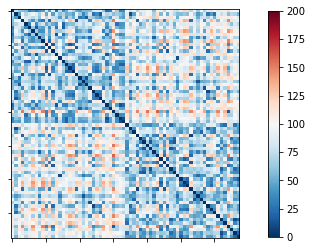

In [11]:
plot_matrix(distance, figure = (4, 4), vmin=0, vmax=200)

## Load Labels

In [12]:
roi_labels = np.loadtxt(os.path.dirname(fc_dir) + '/DK-labels-68.txt', dtype='str')

## Load BOLD

In [89]:
# Load BOLD ROI time-series
BOLD_files = sorted(glob.glob(fc_dir + '/*.csv'))

BOLD_ts = []
for i in BOLD_files:
    sub = os.path.basename(i)[:7]
    
    if sub in subs:
        ts = np.loadtxt(i, delimiter=',')
        BOLD_ts.append(ts)

BOLD_ts = [i[:, -68:] for i in BOLD_ts]
print(len(BOLD_ts))

#mean_ts = # disregard short ts subs



162

## Load FC

In [13]:
# Load correlation matrices
fc = []
for i in fc_files:
    sub = os.path.basename(i)[:7]
    
    if sub in subs:
        cormat = np.loadtxt(i, delimiter=',')
        fc.append(cormat)

fc = np.asarray(fc)    
fc = fc[:, -68:, -68:]
mean_fc = np.mean(fc, axis=0)
np.fill_diagonal(mean_fc, 1)

print('FC Shape:', fc.shape)

FC Shape: (162, 68, 68)


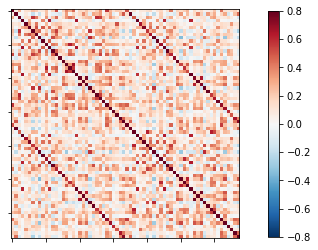

In [14]:
plot_matrix(mean_fc, figure = (4, 4), vmin=-0.8, vmax=0.8)

(array([   222.,   4202.,  27172.,  85126., 158552., 189422., 152470.,
         83528.,  29858.,   7386.]),
 array([-0.85832082, -0.67835216, -0.4983835 , -0.31841485, -0.13844619,
         0.04152246,  0.22149112,  0.40145978,  0.58142843,  0.76139709,
         0.94136574]),
 <BarContainer object of 10 artists>)

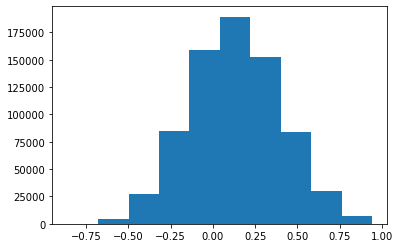

In [15]:
plt.hist(fc[fc!=0].flatten())

# SC-FC Correlation

Pearson correlation R = 0.183, p =  0.0000
Spearman correlation R = 0.172, p =  0.0000


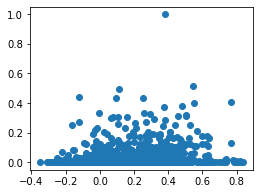

In [645]:
b = matrix_correlation(mean_fc, mean_sc, 68)
b.plot

# Neurolib ALN Model

### Setup ALN

We now create the aln model with a structural connectivity matrix and a delay matrix. In order to achieve a good fit of the BOLD activity to the empirical data, the model has to run for quite a while. A a rule of thumb, a simulation of resting-state BOLD activity should not be shorter than 3 minutes and preferrably longer than 5 minutes real time. If the empirical recordings are for example 10 minues long, ideally, a simulation of 10 minutes would be used to compare the output of the model to the resting state recording.

Duration of simulated activity in ms

In [436]:
aln1 = ALNModel(Cmat = mean_sc, Dmat = distance)

aln1.params['mue_ext_mean'] = 1.57
aln1.params['mui_ext_mean'] = 1.6

# We set an appropriate level of noise
aln1.params['sigma_ou'] = 0.09

# And turn on adaptation with a low value of spike-triggered adaptation currents.
aln.params['b'] = 5.0

#aln1.params['dt'] = 0.2
aln1.params['duration'] = 1*60*1000 
# Info: value 0.2*60*1000 is low for testing
# use 5*60*1000 for real simulation

MainProcess root INFO     aln: Model initialized.


### Plot data

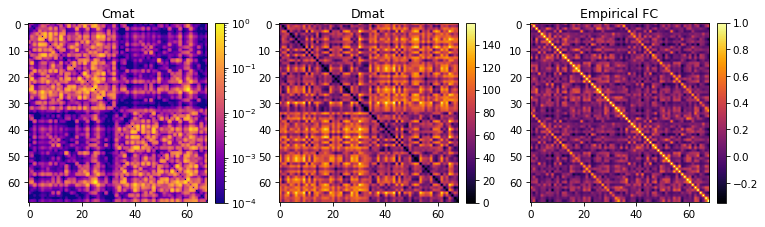

In [437]:
from matplotlib.colors import LogNorm
fig, axs = plt.subplots(1, 3, figsize=(12,8), dpi=75)
fig.subplots_adjust(wspace=0.28)

im = axs[0].imshow(aln1.params['Cmat'], norm=LogNorm(vmin=10e-5, vmax=np.max(aln1.params['Cmat'])))
axs[0].set_title("Cmat")
fig.colorbar(im, ax=axs[0],fraction=0.046, pad=0.04)
im = axs[1].imshow(aln1.params['lengthMat'], cmap='inferno')
axs[1].set_title("Dmat")
fig.colorbar(im, ax=axs[1],fraction=0.046, pad=0.04)
im = axs[2].imshow(mean_fc, cmap='inferno')
axs[2].set_title("Empirical FC")
fig.colorbar(im, ax=axs[2],fraction=0.046, pad=0.04)

### Run model
We run the model with bold simulation by using bold=True. This simulates the Balloon-Windkessel BOLD model in parallel to the neural population model in order to estimate the blood oxigen levels of the underlying neural activity. The output of the bold model can be used to compare the simulated data to empirical fMRI data (resting-state fMRI for example).

To save (a lot of) RAM, we can run the simulation in chunkwise mode. In this mode, the model will be simulated for a length of chunksize steps (not time in ms, but actual integration steps!), and the output of that chunk will be used to automatically reinitiate the model with the appropriate initial conditions. This allows for a serial continuation of the model without having to store all the data in memory and is particularly useful for very long and many parallel simulations.

In [438]:
aln1.run(chunkwise=True, chunksize = 100000, bold=True)

### Results

In [ ]:
aln.outputs

For convenience, they can also be accessed directly using attributes of the model with the outputs name, like aln.rates_exc. The outputs are also available as xr DataArrays as aln.xr().

The since we used bold=True to simulate BOLD, we can also access aln.BOLD.BOLD for the actual BOLD activity, and aln.BOLD.t for the time steps of the BOLD simulation (which are downsampled to 0.5 Hz by default).

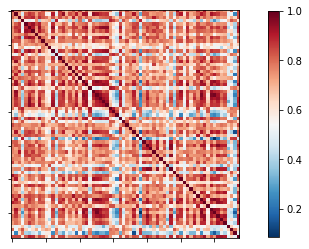

In [439]:
sim_fc = func.fc(aln1.BOLD.BOLD)
plot_matrix(sim_fc, figure = (4,4))

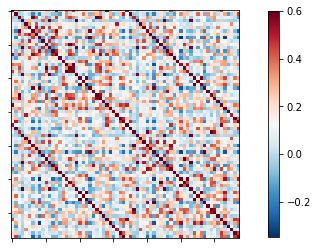

In [419]:
plot_matrix(mean_fc, figure = (4,4), vmax=0.6)

## Neurolib plot results

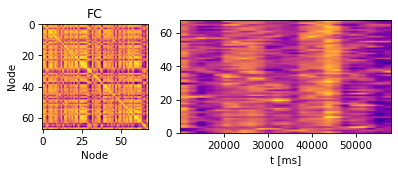

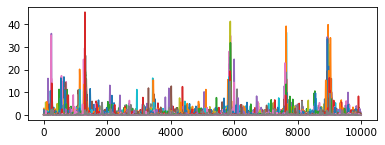

In [447]:
# Plot functional connectivity and BOLD timeseries (z-scored)
fig, axs = plt.subplots(1, 2, figsize=(6, 2), dpi=75, gridspec_kw={'width_ratios' : [1, 2]})
axs[0].imshow(func.fc(aln1.BOLD.BOLD))
axs[1].imshow(scipy.stats.mstats.zscore(aln1.BOLD.BOLD[:, aln1.BOLD.t_BOLD>10000], axis=1), aspect='auto', 
              extent=[aln1.BOLD.t_BOLD[aln1.BOLD.t_BOLD>10000][0], aln1.BOLD.t_BOLD[-1], 0, aln1.params['N']]);

axs[0].set_title("FC")
axs[0].set_xlabel("Node")
axs[0].set_ylabel("Node")
axs[1].set_xlabel("t [ms]")

# the results of the model are also accesible through an xarray DataArray
fig, axs = plt.subplots(1, 1, figsize=(6, 2), dpi=75)
plt.plot(aln1.xr().time, aln1.xr().loc['rates_exc'].T);

### Correlation of simulated BOLD to empirical data

We can compute the element-wise Pearson correlation of the functional connectivity matrices of the simulated data to the empirical data to estimate how well the model captures the inter-areal BOLD correlations found in empirical resting-state recordings. 

In [434]:
scores = [func.matrix_correlation(func.fc(aln1.BOLD.BOLD), fcemp) for fcemp in fc]

print("Correlation per subject:", [f"{s:.2}" for s in scores])
print(f"Mean FC/FC correlation: {np.mean(scores):.2}")

Correlation per subject: ['0.029', '0.072', '0.013', '0.089', '0.014', '0.037', '0.036', '0.064', '0.048', '0.074', '-0.017', '-0.016', '0.11', '-0.0046', '0.069', '0.074', '0.1', '0.047', '0.064', '0.13', '-0.0017', '0.11', '0.027', '0.15', '0.12', '0.055', '0.092', '0.078', '0.074', '0.032', '0.051', '0.0085', '0.038', '0.035', '0.076', '0.015', '0.072', '0.049', '0.034', '0.066', '0.022', '0.076', '0.029', '0.059', '0.098', '0.031', '-0.014', '0.1', '0.052', '0.046', '0.026', '0.038', '0.1', '0.032', '0.13', '0.032', '0.039', '0.05', '0.17', '0.0037', '0.07', '-0.0018', '0.093', '0.025', '0.027', '0.034', '0.036', '0.014', '0.019', '0.044', '0.0014', '0.081', '0.044', '0.041', '0.036', '0.0089', '0.031', '0.11', '0.071', '0.0046', '0.13', '0.036', '0.052', '0.11', '0.066', '0.084', '0.13', '0.056', '-0.019', '0.033', '0.017', '0.042', '0.047', '0.044', '0.066', '0.082', '0.021', '0.023', '0.016', '0.072', '0.067', '0.05', '0.044', '0.03', '0.051', '-0.008', '0.023', '0.053', '0.0027

In [435]:
func.matrix_correlation(func.fc(aln1.BOLD.BOLD), mean_fc)

0.06913522896638546

# Parameter exploration with custom run function and postprocessing

This notebook demonstrates how to scan the parameter space of a brain network model  using `neurolib` with a custom evaluation function to quickly find regions of interest. The evaluation function is designed to increase the speed for the exploration by focussing on regions where the simulated dynamics meets certain criteria. For this, the simulation is run in multiple, successive steps, that increase in duration.

#### Iterative evaluation 

The evaluation of a simulation takes multiple steps: 
- Step 1 runs for a few seconds and checks if there is any rate activity at all
- Step 2 runs a bit longer and checks if there is any BOLD activity
- Step 3 runs the full simulation

#### Postprocessing

In this scenario, we want to postprocess the simulated data as soon as the simulation is done and before writing the results to the hard disk. After the full simulation is run, the funciotnal connectivity (FC) of the BOLD signal is computed and compared to the empirical FC dataset. The Pearson correlation of the FC matrices is computed and the average is taken. We then tell pypet to save these postprocessed results along with the model output.

# Set up model

In [507]:
model = ALNModel(Cmat = mean_sc, Dmat = distance) # simulates the whole-brain model in 10s chunks by default if bold == True
# Resting state fits
model.params['mue_ext_mean'] = 1.57
model.params['mui_ext_mean'] = 1.6
#model.params['sigma_ou'] = 0.09
#model.params['a'] = 5.0
model.params['b'] = 5.0
model.params['dt'] = 0.2
model.params['duration'] = 1 * 60 * 1000 #ms
# testing: model.params['duration'] = 0.2 * 60 * 1000 #ms
# real: model.params['duration'] = 1.0 * 60 * 1000 #ms

MainProcess root INFO     aln: Model initialized.


# Define evaluation function

In [508]:
def evaluateSimulation(traj):
    # get the model from the trajectory using `search.getModelFromTraj(traj)`
    model = search.getModelFromTraj(traj)
    # initiate the model with random initial contitions
    model.randomICs()
    defaultDuration = model.params['duration']
    invalid_result = {"fc" : np.nan, "fcd" : np.nan}
    
    # -------- STAGEWISE EVALUATION  --------
    stagewise = True
    if stagewise:
        # -------- stage wise simulation --------

        # Stage 1 : simulate for a few seconds to see if there is any activity
        # ---------------------------------------
        model.params['duration'] = 3*1000.
        model.run()

        # check if stage 1 was successful
        amplitude = np.max(model.output[:, model.t > 500]) - np.min(model.output[:, model.t > 500])
        if amplitude < 0.05:
            search.saveOutputsToPypet(invalid_result, traj)
            return invalid_result, {}

        # Stage 2: simulate BOLD for a few seconds to see if it moves
        # ---------------------------------------
        model.params['duration'] = 30*1000.
        model.run(chunkwise=True, bold = True)

        if np.max(np.std(model.outputs.BOLD.BOLD[:, 10:15], axis=1)) < 1e-5:
            search.saveOutputsToPypet(invalid_result, traj)
            return invalid_result, {}
    
    # Stage 3: full and final simulation
    # ---------------------------------------
    model.params['duration'] = defaultDuration
    model.run(chunkwise=True, bold = True)
    
    # -------- POSTPROCESSING  --------
    # FC matrix correlation to all subject rs-fMRI
    BOLD_TRANSIENT = 10000
    try:
        fc_score = np.mean([func.matrix_correlation(func.fc(model.BOLD.BOLD[:, model.BOLD.t_BOLD > BOLD_TRANSIENT]), emp_fc) for emp_fc in list(fc)])
    except:
        fc_score = np.nan
    
    # FCD to all subject rs-fMRI
    try:
        fcd_score = np.mean([func.ts_kolmogorov(model.BOLD.BOLD[:, model.BOLD.t_BOLD > BOLD_TRANSIENT], list(BOLD_ts)[i]) for i in range(len(list(BOLD_ts)))])
    except:
        fcd_score = np.nan
      
    # let's build the results dictionary
    result_dict = {"fc":fc_score, "fcd":fcd_score, "outputs":model.outputs}
    # we could also save the output of the model by adding to the results_dict like this:
    # result_dict = {"fc" : fc_score, "fcd" : fcd_score, "outputs" : model.outputs}
    
    # Save the results to pypet. 
    # Remember: This has to be dictionary!
    search.saveOutputsToPypet(result_dict, traj)

In [509]:
parameters = ParameterSpace({"mue_ext_mean": np.linspace(0, 3.0, 21), "mui_ext_mean": np.linspace(0, 3.0, 21)})
# info: chose np.linspace(0, 3, 21) or more, values here are low for testing
search = BoxSearch(evalFunction = evaluateSimulation, model=model, parameterSpace=parameters, filename="mue_mui_search_03.hdf")

MainProcess root INFO     Number of processes: 28
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/mue_mui_search_03.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Number of parameter configurations: 441
MainProcess root INFO     BoxSearch: Environment initialized.


In [510]:
search.run()

MainProcess pypet.environment.Environment INFO     I am preparing the Trajectory for the experiment and initialise the store.
MainProcess pypet.environment.Environment INFO     Initialising the storage for the trajectory.
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2020-08-20-12H-35M-43S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2020-08-20-12H-35M-43S`.
MainProcess pypet.environment.Environment INFO     
************************************************************
STARTING runs of trajectory
`results-2020-08-20-12H-35M-43S`.
************************************************************

MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2020-08-20-12H-35M-43S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `resu

In [511]:
search.loadResults(memory_cap=99.9)
print("Number of results: {}".format(len(search.results)))

MainProcess root INFO     Loading results from ./data/hdf/mue_mui_search_03.hdf
MainProcess root INFO     Analyzing trajectory results-2020-08-20-12H-35M-43S
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/mue_mui_search_03.hdf`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading trajectory `results-2020-08-20-12H-35M-43S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `config` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `parameters` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `results` in mode `1`.
MainProcess root INFO     Creating `dfResults` dataframe ...
MainProcess root INFO     Loading all results to `results` dictionary ...
100%|██████████| 441/441 [00:39<00:00, 11.28it/s]
MainProcess root INFO     Aggregating results to `dfResults` ...
100%|██████████| 441/441 [00:00<00:00, 683.57it/s]
MainPr

Number of results: 441


In [513]:
for i in search.dfResults.index:
    search.dfResults.loc[i, 'bold_cc'] = np.mean(search.results[i]['fc'])

search.dfResults = search.dfResults[['mue_ext_mean', 'mui_ext_mean', 'bold_cc']]
search.dfResults = search.dfResults.sort_values('bold_cc', ascending=False)    
search.dfResults[~np.isnan(search.dfResults.bold_cc)]

,mue_ext_mean,mui_ext_mean,bold_cc
241,1.65,1.50,0.075544
313,2.10,2.85,0.070708
312,2.10,2.70,0.070437
314,2.10,3.00,0.059783
193,1.35,0.60,0.059251
...,...,...,...
317,2.25,0.30,-0.073639
430,3.00,1.50,-0.074162
363,2.55,0.90,-0.074589
360,2.55,0.45,-0.079197


# Plot

Text(0, 0.5, 'Input to I')

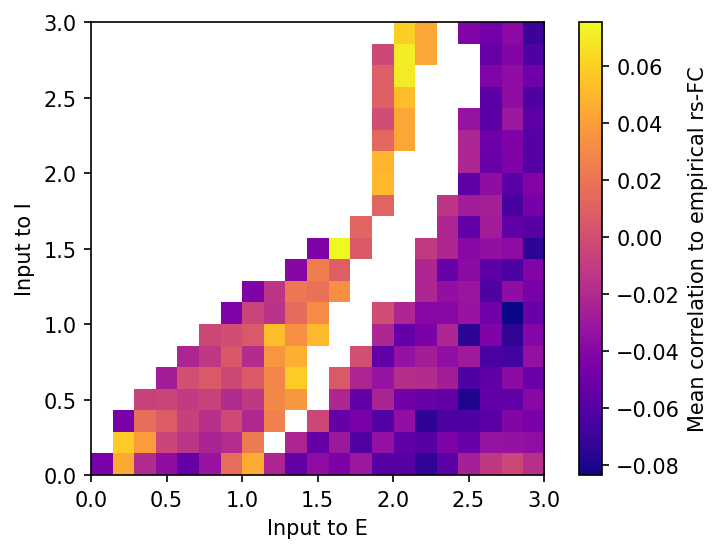

In [514]:
plt.figure(dpi=150)
plt.imshow(search.dfResults.pivot_table(values='bold_cc', index = 'mui_ext_mean', columns='mue_ext_mean'), \
           extent = [min(search.dfResults.mue_ext_mean), max(search.dfResults.mue_ext_mean),
                     min(search.dfResults.mui_ext_mean), max(search.dfResults.mui_ext_mean)], origin='lower')
plt.colorbar(label='Mean correlation to empirical rs-FC')
plt.xlabel("Input to E")
plt.ylabel("Input to I")

## Investigate optimal mui mue parameters in BOLD model

In [515]:
# Find 5 models with optimal params
best_params = search.dfResults.nlargest(5, 'bold_cc')
print(best_params)

     mue_ext_mean  mui_ext_mean   bold_cc
241          1.65          1.50  0.075544
313          2.10          2.85  0.070708
312          2.10          2.70  0.070437
314          2.10          3.00  0.059783
193          1.35          0.60  0.059251


In [574]:
# Select model & update parameters
inputs = best_params.iloc[0]
model.params['mue_ext_mean'] = inputs['mue_ext_mean']
model.params['mui_ext_mean'] = inputs['mui_ext_mean']
param_index = inputs.name

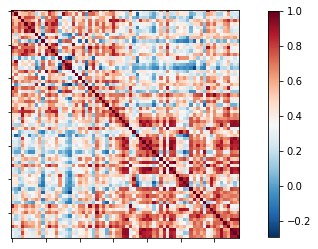

In [575]:
bold = search.results[param_index]['BOLD']
t_bold = search.results[param_index]['t_BOLD']
BOLD_TRANSIENT = 10000

sim_fc = func.fc(bold[:, t_bold > BOLD_TRANSIENT])
#sim_fc = func.fc(model.BOLD.BOLD[:, model.BOLD.t_BOLD > BOLD_TRANSIENT])
plot_matrix(sim_fc, figure = (4,4))

In [576]:
scores = [func.matrix_correlation(sim_fc, fcemp) for fcemp in fc]
print(f"Mean Participant FC/FC correlation: {np.mean(scores):.2}")
print(f'Mean FC/FC correlation: {func.matrix_correlation(sim_fc, mean_fc):.2}')

Mean Participant FC/FC correlation: 0.076
Mean FC/FC correlation: 0.11


In [577]:
scores = [func.matrix_correlation(sim_fc, sc_emp) for sc_emp in sc]
print(f"Mean Participant sim_FC/SC correlation: {np.mean(scores):.2}")
print(f'Mean sim_FC/SC correlation: {func.matrix_correlation(sim_fc, mean_sc):.2}')

Mean Participant sim_FC/SC correlation: 0.29
Mean sim_FC/SC correlation: 0.3


# a, b, mui, mue parameter search

In [580]:
model = ALNModel(Cmat = mean_sc, Dmat = distance) # simulates the whole-brain model in 10s chunks by default if bold == True
# Resting state fits
model.params['mue_ext_mean'] = 1.57
model.params['mui_ext_mean'] = 1.6
#model.params['sigma_ou'] = 0.09
#model.params['a'] = 5.0
model.params['b'] = 5.0
model.params['dt'] = 0.2
model.params['duration'] = 1 * 60 * 1000 #ms
# testing: model.params['duration'] = 0.2 * 60 * 1000 #ms
# real: model.params['duration'] = 1.0 * 60 * 1000 #ms

MainProcess root INFO     aln: Model initialized.


In [581]:
a_list = [float(a) for a in [0, 15, 30]]
b_list = [float(b) for b in [0, 40, 80]]

In [582]:
parameters = ParameterSpace({"mue_ext_mean": np.linspace(0, 3.0, 10), "mui_ext_mean": np.linspace(0, 3.0, 10),
                            "a": a_list, "b": b_list})
# info: chose np.linspace(0, 3, 21) or more, values here are low for testing
search = BoxSearch(evalFunction = evaluateSimulation, model=model, parameterSpace=parameters, filename="ab_mui_mue_search_01.hdf")

MainProcess root INFO     Number of processes: 28
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/ab_mui_mue_search_01.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Number of parameter configurations: 900
MainProcess root INFO     BoxSearch: Environment initialized.


In [583]:
search.run()

MainProcess pypet.environment.Environment INFO     I am preparing the Trajectory for the experiment and initialise the store.
MainProcess pypet.environment.Environment INFO     Initialising the storage for the trajectory.
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2020-08-20-16H-12M-38S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2020-08-20-16H-12M-38S`.
MainProcess pypet.environment.Environment INFO     
************************************************************
STARTING runs of trajectory
`results-2020-08-20-16H-12M-38S`.
************************************************************

MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2020-08-20-16H-12M-38S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `resu

In [603]:
search.loadResults(memory_cap=99.9)
print("Number of results: {}".format(len(search.results)))

MainProcess root INFO     Loading results from ./data/hdf/ab_mui_mue_search_01.hdf
MainProcess root INFO     Analyzing trajectory results-2020-08-20-16H-12M-38S
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/ab_mui_mue_search_01.hdf`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading trajectory `results-2020-08-20-16H-12M-38S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `config` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `parameters` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `results` in mode `1`.
MainProcess root INFO     Creating `dfResults` dataframe ...
MainProcess root INFO     Loading all results to `results` dictionary ...
100%|██████████| 900/900 [00:45<00:00, 19.75it/s]
MainProcess root INFO     Aggregating results to `dfResults` ...
100%|██████████| 900/900 [00:00<00:00, 1059.05it/s]

Number of results: 900


In [604]:
for i in search.dfResults.index:
    search.dfResults.loc[i, 'bold_cc'] = np.mean(search.results[i]['fc'])

search.dfResults = search.dfResults.sort_values('bold_cc', ascending=False)
search.dfResults[~np.isnan(search.dfResults.bold_cc)]

,mue_ext_mean,mui_ext_mean,a,b,fc,t,rates_inh,rates_exc,IA,t_BOLD,BOLD,bold_cc
469,1.666667,0.666667,0.0,40.0,0.120065,"[0.2, 0.4, 0.6000000000000001, 0.8, 1.0, 1.200...","[[27.106325233421014, 26.577246952885808, 26.0...","[[4.160154425111712, 3.9918300908975786, 3.826...","[[106.58780816808991, 106.513155000649, 106.43...","[0.2, 2000.2, 4000.2000000000003, 6000.2000000...","[[5.532871719005072e-10, 0.06116498120459944, ...",0.120065
478,1.666667,1.000000,0.0,40.0,0.066547,"[0.2, 0.4, 0.6000000000000001, 0.8, 1.0, 1.200...","[[14.541733957235705, 14.10872942630937, 13.68...","[[0.9094786430842008, 0.8689275980669237, 0.82...","[[59.06743217348269, 59.01531616209375, 58.962...","[0.2, 2000.2, 4000.2000000000003, 6000.2000000...","[[5.500135996427957e-10, 0.0578786048132005, 0...",0.066547
884,3.000000,2.666667,0.0,80.0,0.063726,"[0.2, 0.4, 0.6000000000000001, 0.8, 1.0, 1.200...","[[86.4848889085028, 86.48549951827873, 86.4861...","[[12.743828827822542, 12.744798894564006, 12.7...","[[208.2499930352087, 208.2456598244865, 208.24...","[0.2, 2000.2, 4000.2000000000003, 6000.2000000...","[[5.507044951613693e-10, 0.06113871709401087, ...",0.063726
850,3.000000,1.333333,15.0,40.0,0.061489,"[0.2, 0.4, 0.6000000000000001, 0.8, 1.0, 1.200...","[[14.212399201276646, 14.582139699819356, 14.9...","[[4.196957471364285, 4.226467582353103, 4.2514...","[[298.1821366389977, 298.2373890681271, 298.29...","[0.2, 2000.2, 4000.2000000000003, 6000.2000000...","[[5.49523207826752e-10, 0.04157780161280529, 0...",0.061489
387,1.333333,1.000000,0.0,0.0,0.055932,"[0.2, 0.4, 0.6000000000000001, 0.8, 1.0, 1.200...","[[33.20955362281764, 34.25528698341959, 35.259...","[[23.551743425539044, 23.355657474250183, 23.1...","[[4.408104613577105e-192, 4.403696508963528e-1...","[0.2, 2000.2, 4000.2000000000003, 6000.2000000...","[[5.503874018764065e-10, 0.05793021708658852, ...",0.055932
...,...,...,...,...,...,...,...,...,...,...,...,...
864,3.000000,2.000000,0.0,0.0,-0.068876,"[0.2, 0.4, 0.6000000000000001, 0.8, 1.0, 1.200...","[[84.0294209856874, 84.02921431059829, 84.0293...","[[65.72910039235845, 65.72890700465199, 65.728...","[[4.408104613577105e-192, 4.403696508963528e-1...","[0.2, 2000.2, 4000.2000000000003, 6000.2000000...","[[5.565446483224432e-10, 0.054582901429171174,...",-0.068876
891,3.000000,3.000000,0.0,0.0,-0.070097,"[0.2, 0.4, 0.6000000000000001, 0.8, 1.0, 1.200...","[[110.49004079423462, 110.48972745814643, 110....","[[63.912459506208855, 63.9125946274562, 63.912...","[[4.408104613577105e-192, 4.403696508963528e-1...","[0.2, 2000.2, 4000.2000000000003, 6000.2000000...","[[5.563456523915988e-10, 0.05484792846226469, ...",-0.070097
882,3.000000,2.666667,0.0,0.0,-0.074212,"[0.2, 0.4, 0.6000000000000001, 0.8, 1.0, 1.200...","[[101.95894560899184, 101.95873249345317, 101....","[[64.41090207654887, 64.41106096512782, 64.411...","[[4.408104613577105e-192, 4.403696508963528e-1...","[0.2, 2000.2, 4000.2000000000003, 6000.2000000...","[[5.563992163004627e-10, 0.05477619040239386, ...",-0.074212
873,3.000000,2.333333,0.0,0.0,-0.076990,"[0.2, 0.4, 0.6000000000000001, 0.8, 1.0, 1.200...","[[93.14208419855166, 93.14189296692902, 93.142...","[[64.99770298984878, 64.9977797870213, 64.9977...","[[4.408104613577105e-192, 4.403696508963528e-1...","[0.2, 2000.2, 4000.2000000000003, 6000.2000000...","[[5.564653449141587e-10, 0.05468934165650177, ...",-0.076990


## Investigate optimal mui, mue, a & b parameters in BOLD model

In [606]:
# Find 5 models with optimal params
best_params = search.dfResults[['mue_ext_mean', 'mui_ext_mean', 'a', 'b', 'bold_cc']]
best_params = best_params.nlargest(5, 'bold_cc')
print(best_params)

     mue_ext_mean  mui_ext_mean     a     b   bold_cc
469      1.666667      0.666667   0.0  40.0  0.120065
478      1.666667      1.000000   0.0  40.0  0.066547
884      3.000000      2.666667   0.0  80.0  0.063726
850      3.000000      1.333333  15.0  40.0  0.061489
387      1.333333      1.000000   0.0   0.0  0.055932


In [607]:
# Select model
inputs = best_params.iloc[0]
param_index = inputs.name

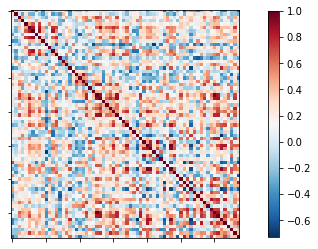

In [608]:
# Compute FC from BOLD
bold = search.results[param_index]['BOLD']
t_bold = search.results[param_index]['t_BOLD']
BOLD_TRANSIENT = 10000

sim_fc = func.fc(bold[:, t_bold > BOLD_TRANSIENT])
#sim_fc = func.fc(model.BOLD.BOLD[:, model.BOLD.t_BOLD > BOLD_TRANSIENT])
plot_matrix(sim_fc, figure = (4,4))

In [609]:
scores = [func.matrix_correlation(sim_fc, fcemp) for fcemp in fc]
print(f"Mean Participant FC/FC correlation: {np.mean(scores):.2}")
print(f'Mean FC/FC correlation: {func.matrix_correlation(sim_fc, mean_fc):.2}')

Mean Participant FC/FC correlation: 0.12
Mean FC/FC correlation: 0.17


Pearson correlation R = 0.173, p =  0.0000
Spearman correlation R = 0.163, p =  0.0000


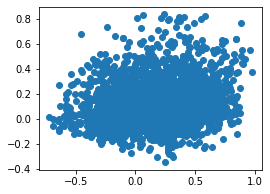

In [647]:
c = matrix_correlation(sim_fc, mean_fc, 68)

In [610]:
scores = [func.matrix_correlation(sim_fc, sc_emp) for sc_emp in sc]
print(f"Mean Participant sim_FC/SC correlation: {np.mean(scores):.2}")
print(f'Mean sim_FC/SC correlation: {func.matrix_correlation(sim_fc, mean_sc):.2}')

Mean Participant sim_FC/SC correlation: 0.27
Mean sim_FC/SC correlation: 0.28


# Simulating a single `aln` node

To create a single node, we simply instanciate the model 
without any arguments. 

In [23]:
# Create the model
aln = ALNModel()

# Each model comes with a set of default parameters which are are a dictionary. 
# Let's change the parameter that controls the duration of a simulation to 10s.
aln.params['duration'] = 10.0 * 1000  

# For convenience, we could also use:
aln.params.duration = 10.0 * 1000

# In the aln model an Ornstein-Uhlenbeck process is simulated in parallel
# as the source of input noise fluctuations. Here we can set the variance
# of the process. 
# For more info: https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process 
# Let's add some noise.
aln.params['sigma_ou'] = 0.1

# Finally, we run the model
aln.run()

### Accessing the outputs

Accessing the outputs is straight-forward. Every model's outputs
are stored in the `model.outputs` attribute. According to the specific
name of each of the model's outputs, they can also be accessed as a 
key of the Model object, i.e. `aln['rates_exc']`.

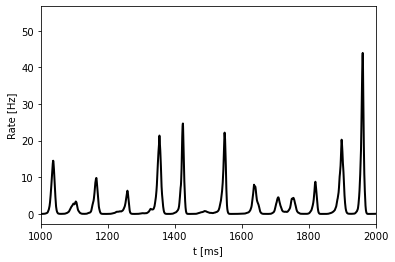

In [24]:
plt.plot(aln['t'], aln['rates_exc'].T, lw=2, c='k')
plt.xlabel("t [ms]")
plt.ylabel("Rate [Hz]")
plt.xlim(1000, 2000);

In [25]:
# Outputs are also available as an xr DataArray
xr = aln.xr()
print(xr.dims)
# outputs can also be accessed via attributes in dot.notation
print("rates_exc", aln.rates_exc)

('output', 'space', 'time')
rates_exc [[25.39311429 23.58202063 21.89372973 ... 26.76641087 26.12928281
  25.55813394]]


## Bifurcation diagram

Bifurcation diagrams can give us an overview of how different parameters of the model affect its dynamics. The simplest method for drawing a bifurcation diagram is to simply change relevant parameters step by step and record the model's behavior in response to these changes. In this example, we want to see how the model's dynamics changes with respect to the **external input currents** to the excitatory population. These input currents could be due to couplings with other nodes in a brain network or we could model other factors like external electrical stimulation. 

Below, you can see a schematic of the `aln` model. As you can see, a single node consists of one excitatory (red) and one inhibitory population (blue). The parameter that controls the mean input to the excitatory population is $\mu_{E}$ or `aln.params["mue_ext_mean"]` .

<p align="center">
  <img src="../resources/aln.png" width="400">
</p>

Let's first decrease the duration of a single run so we can scan the parameter space a bit faster and let's also disable the noisy input.

In [26]:
aln.params['duration'] = 2.0 * 1000  
aln.params['sigma_ou'] = 0.0

Let's fix the input to the inhibitory population:

In [27]:
aln.params['mui_ext_mean'] = 0.5

We draw a one-dimensional bifurcation diagram, so it is enough to loop through different values of `mue_ext_mean` and record the minimum and maximum of the rate for each parameter.

In [28]:
max_rate_e = []
min_rate_e = []
# these are the different input values that we want to scan
mue_inputs = np.linspace(0, 2, 50)
for mue in mue_inputs:
    # Note: this has to be a vector since it is input for all nodes
    # (but we have only one node in this example)
    aln.params['mue_ext_mean'] = mue
    aln.run()
    # we add the maximum and the minimum of the last second of the 
    # simulation to a list
    max_rate_e.append(np.max(aln.output[0, -int(1000/aln.params['dt']):]))
    min_rate_e.append(np.min(aln.output[0, -int(1000/aln.params['dt']):]))

Let's plot the results!

Text(0, 0.5, 'Min / max firing rate')

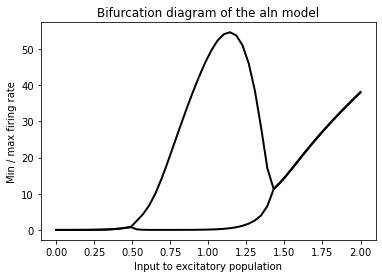

In [29]:
plt.plot(mue_inputs, max_rate_e, c='k', lw = 2)
plt.plot(mue_inputs, min_rate_e, c='k', lw = 2)
plt.title("Bifurcation diagram of the aln model")
plt.xlabel("Input to excitatory population")
plt.ylabel("Min / max firing rate")

# Search Parameter space

### Change model parameters to find similar empirical FC

In [52]:
from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.optimize.exploration import BoxSearch

In [60]:
aln = ALNModel(Cmat = mean_sc, Dmat = distance)

aln.params['duration'] = 0.2*60*1000 
# Info: value 0.2*60*1000 is low for testing
# use 5*60*1000 for real simulation

aln.params['mue_ext_mean'] = 1.57
aln.params['mui_ext_mean'] = 1.6
# We set an appropriate level of noise
aln.params['sigma_ou'] = 0.09
# And turn on adaptation with a low value of spike-triggered adaptation currents.
aln.params['b'] = 5.0

MainProcess root INFO     aln: Model initialized.


### Model optimisation


After some optimization to the resting-state fMRI data of the dataset, we found a set of parameters that creates interesting whole-brain dynamics. We set the mean input of the excitatory and the inhibitory population to be close to the E-I limit cycle.

In [61]:
parameters = ParameterSpace({"mue_ext_mean": np.linspace(0, 3, 21), "mui_ext_mean": np.linspace(0, 3, 21)})
# info: chose np.linspace(0, 3, 21) or more, values here are low for testing
search = BoxSearch(aln, parameters, filename="fc_optimisation.hdf")

MainProcess root INFO     Number of processes: 28
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/fc_optimisation.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Number of parameter configurations: 441
MainProcess root INFO     BoxSearch: Environment initialized.


In [64]:
search.run(chunkwise=True, chunksize = 100000, bold=True)

MainProcess pypet.environment.Environment INFO     I am preparing the Trajectory for the experiment and initialise the store.
MainProcess pypet.environment.Environment INFO     Initialising the storage for the trajectory.
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2020-08-10-17H-58M-43S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2020-08-10-17H-58M-43S`.
MainProcess pypet.environment.Environment INFO     
************************************************************
STARTING runs of trajectory
`results-2020-08-10-17H-58M-43S`.
************************************************************

MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2020-08-10-17H-58M-43S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `resu

In [66]:
search.loadResults(all=False)

MainProcess root INFO     Loading results from ./data/hdf/fc_optimisation.hdf
MainProcess root INFO     Analyzing trajectory results-2020-08-10-17H-58M-43S
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/fc_optimisation.hdf`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading trajectory `results-2020-08-10-17H-58M-43S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `config` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `parameters` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `results` in mode `1`.
MainProcess root INFO     Creating `dfResults` dataframe ...
MainProcess root INFO     Aggregating results to `dfResults` ...
100%|██████████| 441/441 [01:58<00:00,  3.71it/s]
MainProcess root INFO     All results loaded.


In [67]:
print("Number of results: {}".format(len(search.results)))

Number of results: 0


In [3]:
def optimise_fc(traj):
    pars = search.getParametersFromTraj(traj)
    # let's calculate the distance to a circle
    computation_result = abs((pars['x']**2 + pars['y']**2) - 1)
    result_dict = {"distance" : computation_result}
    search.saveOutputsToPypet(result_dict, traj)

In [8]:
# Example analysis of the results
# The .results attribute is a list and can be indexed by the run 
# number (which is also the index of the pandas dataframe .dfResults).
# Here we compute the maximum firing rate of the node in the last second
# and add the result (a float) to the pandas dataframe.
for i in search.dfResults.index:
    search.dfResults.loc[i, 'max_r'] = np.max(search.results[i]['rates_exc'][:, -int(1000/aln.params['dt']):])

Text(0, 0.5, 'Input to I')

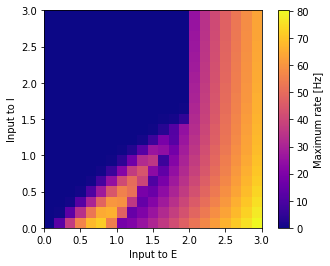

In [16]:
plt.imshow(search.dfResults.pivot_table(values='max_r', index = 'mui_ext_mean', columns='mue_ext_mean'), \
           extent = [min(search.dfResults.mue_ext_mean), max(search.dfResults.mue_ext_mean),
                     min(search.dfResults.mui_ext_mean), max(search.dfResults.mui_ext_mean)], origin='lower')
plt.colorbar(label='Maximum rate [Hz]')
plt.xlabel("Input to E")
plt.ylabel("Input to I")

In [99]:
aln.params['mue_ext_mean'] = 1.57
aln.params['mui_ext_mean'] = 1.6
# We set an appropriate level of noise
aln.params['sigma_ou'] = 0.09
# And turn on adaptation with a low value of spike-triggered adaptation currents.
aln.params['b'] = 5.0

In [112]:
aln.run(chunkwise=True, chunksize = 100000, bold=True)